# Inconsitent sample sizes

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, join, unique, Column

In [2]:
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

# How many stars do we have lightcurves for and how many have been observed more than once?

In [11]:
make_obstargets=False
debug=True

In [12]:
obstargetsfile = 'Corot_observedgiants.csv'
if not make_obstargets:
    obstargets = Table.read(obstargetsfile, format='csv')
else:
    convert = False
    runs = ['IRa01', 'LRa01',
            'LRa02', 'LRa03', 'LRa04', 'LRa05', 'LRa06', 'LRa07',
            'LRc01', 'LRc02', 'LRc03', 'LRc04', 'LRc05', 'LRc06',
            'LRc07', 'LRc08', 'LRc09', 'LRc10']
    maindir = './rawdata/'
    prefix = 'CRT0'
    stars = []
    multi = []
    starruns = {}
    for run in runs:
        rundir = os.path.join(maindir, run + 'RGPPSD', run + 'RG', 'PSD/')
        assert os.path.exists(rundir)
        outputdir = os.path.join('./data/', run)
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        for s in os.listdir(rundir):
            hdulist = fits.open(os.path.join(rundir, s))
            cid = hdulist[0].header['corotid']
            if cid in starruns:
                multi.append([cid, run])
            else:
                stars.append(cid)
            starruns.setdefault(cid, []).append(run)
            if convert:
                data = hdulist[0].data.T
                data[0] *= 1e6  # convet from hertz to microhertz
                np.savetxt(
                    os.path.join(outputdir, prefix + str(cid) + '.txt'),
                    data.T)
    print(f'We have {len(starruns)} unique stars with lightcurves')
    twice = []
    trice = []
    multi = []

    for key, value in starruns.items():
        if len(value) == 2:
            twice.append(key)
        if len(value) == 3:
            trice.append(key)
        if len(value) > 3:
            multi.append(key)

    print(f'{len(twice)} of these have been observed 2 times')
    print(f'{len(trice)} have been observed 3 times')
    print(f'{len(multi)} have been observed more than 3 times')
    keys = []
    values = []
    for (k, v) in starruns.items():
        keys.append(k)
        values.append(''.join(str(v)))
    # Convert to a table like the others
    obstargets = Table([keys, values], names=('corot_id', 'run_ids'))
    if debug:
        print('')
        print('* DEBUG *')
        # Test that the making of the table was successfull
        testtarget = 102724327
        print(obstargets[0:10])

        specific_runid = 'IRa01'
        runmask = [specific_runid in run_ids for run_ids in obstargets['run_ids']]
        print(obstargets[runmask])
    obstargets.write(obstargetsfile, format='csv')

## How many of these stars are in Giada's table and in StarHorse?

In [13]:
projectidstr = 'corot'
giadatable = 'Corot_giants_newBC_newlogg_final.csv'
starhorsetable = 'CoRoT_SH_1.fits'
giadatable_old = 'Corot_table_final2_allstars.csv'

dirp = os.path.join('projects', projectidstr)

spectrotable = Table.read(os.path.join(dirp, giadatable), format='csv')
shtable = Table.read(os.path.join(dirp, starhorsetable), format='fits')
spectrotable_old = Table.read(os.path.join(dirp, giadatable_old), format='csv')

# The old table has 3463 stars with no source_id
spectrotable_old = spectrotable_old[~spectrotable_old['source_id'].mask]

# The new table should have been made using the following mask
currentmask = (
    (spectrotable_old['flag_mag'] == 2) |
    (spectrotable_old['flag_logg_2M'] == 2)
)
print(f'The current mask removes {np.sum(~currentmask)} stars')
spectrotable_mask = spectrotable_old[currentmask]

# Giada and I discussed just using the cut in absolute magnitude
magmask = ((spectrotable_old['flag_mag'] == 2))
print(f'The new mask removes {np.sum(~magmask)} stars')
spectrotable_new = spectrotable_old[magmask]

overlap = {}
print('')

for tidstr, table in zip(
    [
    "Giada's table",
    'StarHorse',
    "Giada's old table",
    "Giada's old table with current mask",
    "Giada's old table with new mask",
    ],
    [
     spectrotable,
     shtable,
     spectrotable_old,
     spectrotable_mask,
     spectrotable_new,
    ]):
    print(f'For {tidstr}, the length of the table is {len(table)}')
    for starid in ['corot_id', 'source_id']:
        if starid in table.columns:
            print(f'{len(np.unique(table[starid]))} of these have unique {starid}')
    starid = 'corot_id'
    if starid in table.columns:
        a = join(table, obstargets, keys=starid, join_type='inner')
        print(f'Overlap with astropy table is {len(a)}')
        print(f'Unique overlap with astropy table is {len(np.unique(a[starid]))}')
        print(f'The number of extra targets are {len(set(table[starid]) - set(obstargets[starid]))}')
    print('')

The current mask removes 108053 stars
The new mask removes 108548 stars

For Giada's table, the length of the table is 62548
58454 of these have unique corot_id
58274 of these have unique source_id
Overlap with astropy table is 45587
Unique overlap with astropy table is 42040
The number of extra targets are 16414

For StarHorse, the length of the table is 38867
38827 of these have unique source_id

For Giada's old table, the length of the table is 173339
160264 of these have unique corot_id
160022 of these have unique source_id
Overlap with astropy table is 45616
Unique overlap with astropy table is 42040
The number of extra targets are 118224

For Giada's old table with current mask, the length of the table is 62548
58454 of these have unique corot_id
58385 of these have unique source_id
Overlap with astropy table is 45587
Unique overlap with astropy table is 42040
The number of extra targets are 16414

For Giada's old table with new mask, the length of the table is 62053
57962 of the

## Check overlap with Starhorse

In [14]:
joined = {}
shoverlap = {}
for tidstr, table in zip([
    "Giada's table",
    "Giada's old table",
    "Giada's old table with current mask",
    "Giada's old table with new mask",
    ],
    [
     spectrotable,
     spectrotable_old,
     spectrotable_mask,
     spectrotable_new,
    ]):
    joined[tidstr] = join(table, shtable,
                          keys=['source_id'], join_type='inner')
    print(len(joined[tidstr]['source_id']))
    print(len(np.unique(joined[tidstr]['source_id'])))

    shoverlap[tidstr] = []
    for key in starruns.keys():
        if key in joined[tidstr]['corot_id']:
            shoverlap[tidstr].append(key)
            
    shoverlap_twice = []
    for key in twice:
        if key in joined[tidstr]['corot_id']:
            shoverlap_twice.append(key)

    shoverlap_trice = []
    for key in trice:
        if key in joined[tidstr]['corot_id']:
            shoverlap_trice.append(key)

    print(f'Overlap between {tidstr} and Starhorse is {len(joined[tidstr]["source_id"])}')
    print(f'{len(np.unique(joined[tidstr]["source_id"]))} have unique source id')
    print(f'{len(shoverlap_twice)} was observed 2 times')
    print(f'{len(shoverlap_trice)} was observed 3 times')
    print('')

10728
9828


NameError: name 'starruns' is not defined

In [8]:
for tidstr, table in zip([
    "Giada's old table",
    "Giada's old table with current mask",
    "Giada's old table with new mask",
    ],
    [
        spectrotable_old,
     spectrotable_mask,
     spectrotable_new,
    ]):
    missing = []
    
    for star in shtable['source_id']:
        if star not in table['source_id']:
            missing.append(star)
            
    if len(missing) > 0:
        print(f'Stars in {tidstr} not in Starhorse are:')
        print(missing)

In [9]:
# Why do we have multiple source_ids in starhorse?
stars, v = np.unique(shtable['source_id'], return_counts=True)

multistars = stars[v > 1]
print(len(multistars))
col = 'dist05'

# print(shtable[np.isin(shtable['source_id'], multistars)])
for ustar in multistars:
    umask = (shtable['source_id'] == ustar)
    if (shtable[col][umask][0] - shtable[col][umask][1]) != 0:
        print(ustar)

40


# Write new table for crossmatching

In [15]:
newtablename = 'Corot_giants_v2.csv'
make_writetable=True

spectrotable_old = Table.read(os.path.join(dirp, giadatable_old), format='csv')
#spectrotable_old = spectrotable_old[~spectrotable_old['source_id'].mask]

mask = ((spectrotable_old['flag_mag'] == 2))
print(f'The new mask removes {np.sum(~mask)} stars')
spectrotable_new = spectrotable_old[mask]

# Add obstargets and make corot_id unique identifier
spectrotable_new = unique(spectrotable_new, keys='corot_id')
spectrotable_new.remove_column('run_id')

# Make table for crossmatch
spectrotable_new = join(obstargets, spectrotable_new, keys='corot_id', join_type='right')

print(f'{np.sum(spectrotable_new["run_ids"].mask)} has no lightcurves')
print(f'{len(spectrotable_new[spectrotable_new["twomass_id"] == "0"])} has no tmass ids')

cols = ['corot_id','twomass_id','ra','dec', 'source_id']
writetable = unique(spectrotable_new, keys='corot_id')

if make_writetable:
    writetable[cols].write(newtablename, overwrite=True)

The new mask removes 108548 stars
16239 has no lightcurves
1390 has no tmass ids


# Tests of new crossmatch with Gaia

In [6]:
skycatsdir = './skycats-tables'
tmasscross = Table.read(os.path.join(skycatsdir,
                                     'corotsamplecat_v0.40.vot'),
                       format='votable')
coordcross = Table.read(os.path.join(skycatsdir,
                                     'corotsamplecat_v0.42.vot'),
                       format='votable')
sourceidcross = Table.read(os.path.join(skycatsdir,
                                     'corotsamplecat_v0.43.vot'),
                       format='votable')

In [7]:
sourceidcross

COROT_ID,RA_1,DEC_1,RA_2,DEC_2,AG_GSPPHOT_GAIA,ASTROMETRIC_CHI2_AL_GAIA,ASTROMETRIC_EXCESS_NOISE_GAIA,ASTROMETRIC_EXCESS_NOISE_SIG_GAIA,ASTROMETRIC_GOF_AL_GAIA,ASTROMETRIC_MATCHED_TRANSITS_GAIA,ASTROMETRIC_N_BAD_OBS_AL_GAIA,ASTROMETRIC_N_GOOD_OBS_AL_GAIA,ASTROMETRIC_N_OBS_AL_GAIA,ASTROMETRIC_PARAMS_SOLVED_GAIA,ASTROMETRIC_PRIMARY_FLAG_GAIA,ASTROMETRIC_SIGMA5D_MAX_GAIA,AZERO_GSPPHOT_GAIA,BP_G_GAIA,BP_RP_GAIA,B_GAIA,CLASSPROB_DSC_COMBMOD_GALAXY_GAIA,CLASSPROB_DSC_COMBMOD_QUASAR_GAIA,CLASSPROB_DSC_COMBMOD_STAR_GAIA,DEC_GAIA,DEC_PARALLAX_CORR_GAIA,DEC_PMDEC_CORR_GAIA,DEC_PMRA_CORR_GAIA,DEC_PSEUDOCOLOUR_CORR_GAIA,DISTANCE_GSPPHOT_GAIA,DUPLICATED_SOURCE_GAIA,EBPMINRP_GSPPHOT_GAIA,ECL_LAT_GAIA,ECL_LON_GAIA,ERROR_DEC_GAIA,ERROR_GRVS_MAG_GAIA,ERROR_LOS_VELOCITY_GAIA,ERROR_PARALLAX_UNCORRECTED_GAIA,ERROR_PHOT_BP_MEAN_FLUX_GAIA,ERROR_PHOT_G_MEAN_FLUX_GAIA,ERROR_PHOT_RP_MEAN_FLUX_GAIA,ERROR_PMDEC_UNCORRECTED_GAIA,ERROR_PMRA_UNCORRECTED_GAIA,ERROR_RA_GAIA,ERROR_VBROAD_GAIA,GRVS_MAG_GAIA,GRVS_MAG_NB_TRANSITS_GAIA,G_RP_GAIA,HAS_EPOCH_PHOTOMETRY_GAIA,HAS_EPOCH_RV_GAIA,HAS_MCMC_GSPPHOT_GAIA,HAS_MCMC_MSC_GAIA,HAS_RVS_GAIA,HAS_XP_CONTINUOUS_GAIA,HAS_XP_SAMPLED_GAIA,IN_ANDROMEDA_SURVEY_GAIA,IN_GALAXY_CANDIDATES_GAIA,IN_QSO_CANDIDATES_GAIA,IPD_FRAC_MULTI_PEAK_GAIA,IPD_FRAC_ODD_WIN_GAIA,IPD_GOF_HARMONIC_AMPLITUDE_GAIA,IPD_GOF_HARMONIC_PHASE_GAIA,LIBNAME_GSPPHOT_GAIA,LOGG_GSPPHOT_GAIA,LOS_VELOCITY_GAIA,LOWER_ERROR_AG_GSPPHOT_GAIA,LOWER_ERROR_AZERO_GSPPHOT_GAIA,LOWER_ERROR_DISTANCE_GSPPHOT_GAIA,LOWER_ERROR_EBPMINRP_GSPPHOT_GAIA,LOWER_ERROR_LOGG_GSPPHOT_GAIA,LOWER_ERROR_MH_GSPPHOT_GAIA,LOWER_ERROR_TEFF_GSPPHOT_GAIA,L_GAIA,MATCHED_TRANSITS_GAIA,MATCHED_TRANSITS_REMOVED_GAIA,UNCALIBRATED_MH_GSPPHOT_GAIA,NEW_MATCHED_TRANSITS_GAIA,NON_SINGLE_STAR_GAIA,NU_EFF_ASTROMETRY_GAIA,UNCORRECTED_PARALLAX_GAIA,PARALLAX_OVER_ERROR_GAIA,PARALLAX_PMDEC_CORR_GAIA,PARALLAX_PMRA_CORR_GAIA,PARALLAX_PSEUDOCOLOUR_CORR_GAIA,PHOT_BP_MEAN_FLUX_GAIA,PHOT_BP_MEAN_MAG_GAIA,PHOT_BP_N_BLENDED_TRANSITS_GAIA,PHOT_BP_N_CONTAMINATED_TRANSITS_GAIA,PHOT_BP_N_OBS_GAIA,PHOT_BP_RP_EXCESS_FACTOR_GAIA,PHOT_G_MEAN_FLUX_GAIA,PHOT_G_MEAN_MAG_GAIA,PHOT_G_N_OBS_GAIA,PHOT_PROC_MODE_GAIA,PHOT_RP_MEAN_FLUX_GAIA,PHOT_RP_MEAN_MAG_GAIA,PHOT_RP_N_BLENDED_TRANSITS_GAIA,PHOT_RP_N_CONTAMINATED_TRANSITS_GAIA,PMDEC_GAIA,PMDEC_PSEUDOCOLOUR_CORR_GAIA,PMRA_GAIA,PMRA_PMDEC_CORR_GAIA,PMRA_PSEUDOCOLOUR_CORR_GAIA,PSEUDOCOLOUR_ERROR_GAIA,PSEUDOCOLOUR_GAIA,RANDOM_INDEX_GAIA,RA_DEC_CORR_GAIA,RA_GAIA,RA_PARALLAX_CORR_GAIA,RA_PMDEC_CORR_GAIA,RA_PMRA_CORR_GAIA,RA_PSEUDOCOLOUR_CORR_GAIA,REF_EPOCH_GAIA,RUWE_GAIA,RVS_SPEC_SIG_TO_NOISE_GAIA,RV_AMPLITUDE_ROBUST_GAIA,RV_ATM_PARAM_ORIGIN_GAIA,RV_CHISQ_PVALUE_GAIA,RV_EXPECTED_SIG_TO_NOISE_GAIA,RV_METHOD_USED_GAIA,RV_NB_DEBLENDED_TRANSITS_GAIA,RV_NB_TRANSITS_GAIA,RV_RENORMALISED_GOF_GAIA,RV_TEMPLATE_FE_H_GAIA,RV_TIME_DURATION_GAIA,RV_VISIBILITY_PERIODS_USED_GAIA,SCAN_DIRECTION_MEAN_K1_GAIA,SCAN_DIRECTION_MEAN_K2_GAIA,SCAN_DIRECTION_MEAN_K3_GAIA,SCAN_DIRECTION_MEAN_K4_GAIA,SCAN_DIRECTION_STRENGTH_K1_GAIA,SCAN_DIRECTION_STRENGTH_K2_GAIA,SCAN_DIRECTION_STRENGTH_K3_GAIA,SCAN_DIRECTION_STRENGTH_K4_GAIA,SOLUTION_ID_GAIA,TEFF_GSPPHOT_GAIA,TOTALPM_GAIA,UPPER_ERROR_AG_GSPPHOT_GAIA,UPPER_ERROR_AZERO_GSPPHOT_GAIA,UPPER_ERROR_DISTANCE_GSPPHOT_GAIA,UPPER_ERROR_EBPMINRP_GSPPHOT_GAIA,UPPER_ERROR_LOGG_GSPPHOT_GAIA,UPPER_ERROR_MH_GSPPHOT_GAIA,UPPER_ERROR_TEFF_GSPPHOT_GAIA,VBROAD_GAIA,VBROAD_NB_TRANSITS_GAIA,VISIBILITY_PERIODS_USED_GAIA,DISTANCE_GEO_BAILERJONES,DISTANCE_PHOTGEO_BAILERJONES,FLAG_BAILERJONES,LOWER_ERROR_DISTANCE_GEO_BAILERJONES,LOWER_ERROR_DISTANCE_PHOTGEO_BAILERJONES,UPPER_ERROR_DISTANCE_GEO_BAILERJONES,UPPER_ERROR_DISTANCE_PHOTGEO_BAILERJONES,ABP_GSPPHOT_GAIA,ACTIVITYINDEX_ESPCS_GAIA,ACTIVITYINDEX_ESPCS_INPUT_GAIA,ACTIVITYINDEX_ESPCS_UNCERTAINTY_GAIA,AGE_FLAME_GAIA,AG_ESPHS_GAIA,AG_ESPHS_UNCERTAINTY_GAIA,AG_MSC_GAIA,ALPHAFE_GSPSPEC_GAIA,ARP_GSPPHOT_GAIA,AZERO_ESPHS_GAIA,AZERO_ESPHS_UNCERTAINTY_GAIA,AZERO_MSC_GAIA,BC_FLAME_GAIA,CAFE_GSPSPEC_GAIA,CAFE_GSPSPEC_LINESCATTER_GAIA,CAFE_GSP

In [22]:
testcrossmatch = True
if testcrossmatch:
    def crosstest(table1, table2, cols, checkcols):
        for table, col in zip([table1, table2], cols):
            if isinstance(table[col], str):
                table[col] = table[col].astype(int)
        #mask = (table1[cols[0]].mask) & (table2[cols[1]].mask) & (table1[cols[0]] == '') & (table2[cols[1]] == '')
        mask = np.zeros(len(table1), dtype=bool)
        x = table1[cols[0]][~mask].astype(str)
        y = table2[cols[1]][~mask].astype(str)
        for i in range(len(x)):
            if x[i] != y[i]:
                print(x[i], y[i])
                for j in range(len(checkcols)//2):
                    print(table1[checkcols[(j*2)]][~mask][i], table2[checkcols[(j*2)+1]][~mask][i])
                print('')
    
    if 'corot_id' in writetable.columns:
        writetable.rename_column('corot_id', 'COROT_ID')
    newtable = join(writetable, coordcross, keys='COROT_ID')
    crosstest(
        coordcross,
        writetable,
        ['SOURCE_ID_GAIA', 'source_id'],
        checkcols=['PMRA_GAIA', 'pmra',
                   'PHOT_G_MEAN_MAG_GAIA', 'phot_g_mean_mag',
                   'DUPLICATED_SOURCE_GAIA', 'Jmag',
                   'UNCORRECTED_PARALLAX_GAIA', 'parallax',
                   'LOGG_GSPPHOT_GAIA', 'twomass_id']
    )
    
    from astropy import constants as const
    from astropy import units as u
    fillvalue = -9999

    def estimate_numax(logg, teff, mask=None):
        gsun = ((const.G * const.M_sun) / (const.R_sun) ** 2).to(u.cm / u.second ** 2).value
        loggsun = np.log10(gsun)
        teffsun = 5772  # Kelvin, Prsa et al. 2016
        numaxsun = 3090  # µHz, Huber et al 2011

        # Estimate numax from log g and teff
        numax = ((10 ** (logg - loggsun)) * (teff / teffsun) ** (-1/2) * numaxsun)
        return numax

    issuestars = []
    for i in range(len(newtable)):
        if newtable['source_id'][i].astype(str) != newtable['SOURCE_ID_GAIA'][i]:
            #issuestars.append(newtable['SOURCE_ID_GAIA'][i])
            issuestars.append(newtable['source_id'][i])

    print(np.sum(np.isin(shtable['source_id'].astype(str), np.asarray(issuestars).astype(str))))
    print(len(issuestars))
    #print(shtable[np.isin(shtable['source_id'].astype(str), np.asarray(issuestars).astype(str))])
    smallshtable = shtable[np.isin(shtable['source_id'].astype(str), np.asarray(issuestars).astype(str))]
    for i in range(len(smallshtable)):
        smallmask = newtable['source_id'] == smallshtable['source_id'][i]
            #print(f"choices[{newtable['COROT_ID'][i]}] = ")
        print(newtable['source_id'][smallmask].value, newtable['SOURCE_ID_GAIA'][smallmask].value, smallshtable['source_id'][i])
        print(newtable['COROT_ID'][smallmask].value, newtable['run_ids'][smallmask].value)
        print(newtable['teff'][smallmask].value, smallshtable['teff50'][i])
        print(newtable['logg_photo_2M'][smallmask].value, smallshtable['logg50'][i])
        print(newtable['parallax'][smallmask].value, newtable['PARALLAX_GAIA'][smallmask].value)
        print(estimate_numax(newtable['logg_photo_2M'][smallmask].value, newtable['teff'][smallmask].value, mask=[True]))
        print(estimate_numax(smallshtable['logg50'][i], smallshtable['teff50'][i], mask=[True]))
        print('')

4264555221001255680 4264555221021696256
-5.39273981897251 -1.982
16.569714 16.67383
False 13.774000000000001
0.22073721208479455 0.2262
-9999.0 19225854+0123439

4288668885409279744 4288668881086983680
-1.6788894867010749 -0.961
14.359957 12.852988999999999
False 11.421
0.20931917922938312 0.6302
-9999.0 19251069+0202334

4287822124007832704 4287822124000532224
-3.9007249471946173 -2.638
16.495262 16.526970000000002
False 13.640999999999998
0.3939813589822692 0.2204
-9999.0 19271093+0125305

4287719457086284160 4287719452790524416
-2.6421264420062314 0.684
16.610548 16.635698
False 14.135
0.1362542414070465 0.4068
-9999.0 19282053+0050561

3106082041657307520 3106082041660249600
0.1905307651366714 -1.784
16.420942 15.666044
False 12.829
0.3037685162847455 0.4083
-9999.0 06472520-0250148

4478966482414108032 4478966482422329856
-9999.0 1.445
17.184765 15.330842
False 14.011
-9999.0 0.1903
-9999.0 18332076+0811383

4286340222834727552 4286340222857911808
-9999.0 -3.8360000000000003
16.78

/home/amalie/.local/lib/python3.10/site-packages/numpy/ma/core.py:4121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


In [18]:
newtable['source_id'] = newtable['source_id'].astype(str)
shtable['source_id'] = shtable['source_id'].astype(str)
newtable = join(newtable, shtable, keys='source_id', join_type='left')

In [19]:
newtable

COROT_ID,run_ids,teff,logg_input,feh_input,ebv,ra,dec,twomass_id,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_mag,phot_rp_mean_mag_error,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,AJ,AH,AKs,abs_Jmag,abs_Hmag,abs_Kmag,flag_mag,BC_V_09M,BC_G_09M,BC_J_09M,BC_H_09M,BC_K_09M,BC_V_2M,BC_G_2M,BC_J_2M,BC_H_2M,BC_K_2M,logg_photo_0.9M,logg_photo_2M,flag_logg_09M,flag_logg_2M,TMASS_ID,RA,DEC,ANGULAR_DISTANCE_GAIA,SOURCE_ID_GAIA,AG_GSPPHOT_GAIA,ASTROMETRIC_CHI2_AL_GAIA,ASTROMETRIC_EXCESS_NOISE_GAIA,ASTROMETRIC_EXCESS_NOISE_SIG_GAIA,ASTROMETRIC_GOF_AL_GAIA,ASTROMETRIC_MATCHED_TRANSITS_GAIA,ASTROMETRIC_N_BAD_OBS_AL_GAIA,ASTROMETRIC_N_GOOD_OBS_AL_GAIA,ASTROMETRIC_N_OBS_AL_GAIA,ASTROMETRIC_PARAMS_SOLVED_GAIA,ASTROMETRIC_PRIMARY_FLAG_GAIA,ASTROMETRIC_SIGMA5D_MAX_GAIA,AZERO_GSPPHOT_GAIA,BP_G_GAIA,BP_RP_GAIA,B_GAIA,CLASSPROB_DSC_COMBMOD_GALAXY_GAIA,CLASSPROB_DSC_COMBMOD_QUASAR_GAIA,CLASSPROB_DSC_COMBMOD_STAR_GAIA,DEC_GAIA,DEC_PARALLAX_CORR_GAIA,DEC_PMDEC_CORR_GAIA,DEC_PMRA_CORR_GAIA,DEC_PSEUDOCOLOUR_CORR_GAIA,DISTANCE_GSPPHOT_GAIA,DUPLICATED_SOURCE_GAIA,EBPMINRP_GSPPHOT_GAIA,ECL_LAT_GAIA,ECL_LON_GAIA,ERROR_DEC_GAIA,ERROR_GRVS_MAG_GAIA,ERROR_LOS_VELOCITY_GAIA,ERROR_PARALLAX_UNCORRECTED_GAIA,ERROR_PHOT_BP_MEAN_FLUX_GAIA,ERROR_PHOT_G_MEAN_FLUX_GAIA,ERROR_PHOT_RP_MEAN_FLUX_GAIA,ERROR_PMDEC_UNCORRECTED_GAIA,ERROR_PMRA_UNCORRECTED_GAIA,ERROR_RA_GAIA,ERROR_VBROAD_GAIA,GRVS_MAG_GAIA,GRVS_MAG_NB_TRANSITS_GAIA,G_RP_GAIA,HAS_EPOCH_PHOTOMETRY_GAIA,HAS_EPOCH_RV_GAIA,HAS_MCMC_GSPPHOT_GAIA,HAS_MCMC_MSC_GAIA,HAS_RVS_GAIA,HAS_XP_CONTINUOUS_GAIA,HAS_XP_SAMPLED_GAIA,IN_ANDROMEDA_SURVEY_GAIA,IN_GALAXY_CANDIDATES_GAIA,IN_QSO_CANDIDATES_GAIA,IPD_FRAC_MULTI_PEAK_GAIA,IPD_FRAC_ODD_WIN_GAIA,IPD_GOF_HARMONIC_AMPLITUDE_GAIA,IPD_GOF_HARMONIC_PHASE_GAIA,LIBNAME_GSPPHOT_GAIA,LOGG_GSPPHOT_GAIA,LOS_VELOCITY_GAIA,LOWER_ERROR_AG_GSPPHOT_GAIA,LOWER_ERROR_AZERO_GSPPHOT_GAIA,LOWER_ERROR_DISTANCE_GSPPHOT_GAIA,LOWER_ERROR_EBPMINRP_GSPPHOT_GAIA,LOWER_ERROR_LOGG_GSPPHOT_GAIA,LOWER_ERROR_MH_GSPPHOT_GAIA,LOWER_ERROR_TEFF_GSPPHOT_GAIA,L_GAIA,MATCHED_TRANSITS_GAIA,MATCHED_TRANSITS_REMOVED_GAIA,MH_GSPPHOT_GAIA,NEW_MATCHED_TRANSITS_GAIA,NON_SINGLE_STAR_GAIA,NU_EFF_ASTROMETRY_GAIA,UNCORRECTED_PARALLAX_GAIA,PARALLAX_OVER_ERROR_GAIA,PARALLAX_PMDEC_CORR_GAIA,PARALLAX_PMRA_CORR_GAIA,PARALLAX_PSEUDOCOLOUR_CORR_GAIA,PHOT_BP_MEAN_FLUX_GAIA,PHOT_BP_MEAN_MAG_GAIA,PHOT_BP_N_BLENDED_TRANSITS_GAIA,PHOT_BP_N_CONTAMINATED_TRANSITS_GAIA,PHOT_BP_N_OBS_GAIA,PHOT_BP_RP_EXCESS_FACTOR_GAIA,PHOT_G_MEAN_FLUX_GAIA,PHOT_G_MEAN_MAG_GAIA,PHOT_G_N_OBS_GAIA,PHOT_PROC_MODE_GAIA,PHOT_RP_MEAN_FLUX_GAIA,PHOT_RP_MEAN_MAG_GAIA,PHOT_RP_N_BLENDED_TRANSITS_GAIA,PHOT_RP_N_CONTAMINATED_TRANSITS_GAIA,PMDEC_GAIA,PMDEC_PSEUDOCOLOUR_CORR_GAIA,PMRA_GAIA,PMRA_PMDEC_CORR_GAIA,PMRA_PSEUDOCOLOUR_CORR_GAIA,PSEUDOCOLOUR_ERROR_GAIA,PSEUDOCOLOUR_GAIA,RANDOM_INDEX_GAIA,RA_DEC_CORR_GAIA,RA_GAIA,RA_PARALLAX_CORR_GAIA,RA_PMDEC_CORR_GAIA,RA_PMRA_CORR_GAIA,RA_PSEUDOCOLOUR_CORR_GAIA,REF_EPOCH_GAIA,RUWE_GAIA,RVS_SPEC_SIG_TO_NOISE_GAIA,RV_AMPLITUDE_ROBUST_GAIA,RV_ATM_PARAM_ORIGIN_GAIA,RV_CHISQ_PVALUE_GAIA,RV_EXPECTED_SIG_TO_NOISE_GAIA,RV_METHOD_USED_GAIA,RV_NB_DEBLENDED_TRANSITS_GAIA,RV_NB_TRANSITS_GAIA,RV_RENORMALISED_GOF_GAIA,RV_TEMPLATE_FE_H_GAIA,RV_TIME_DURATION_GAIA,RV_VISIBILITY_PERIODS_USED_GAIA,SCAN_DIRECTION_MEAN_K1_GAIA,SCAN_DIRECTION_MEAN_K2_GAIA,SCAN_DIRECTION_MEAN_K3_GAIA,SCAN_DIRECTION_MEAN_K4_GAIA,SCAN_DIRECTION_STRENGTH_K1_GAIA,SCAN_DIRECTION_STRENGTH_K2_GAIA,SCAN_DIRECTION_STRENGTH_K3_GAIA,SCAN_DIRECTION_STRENGTH_K4_GAIA,SOLUTION_ID_GAIA,TEFF_GSPPHOT_GAIA,TOTALPM_GAIA,UPPER_ERROR_AG_GSPPHOT_GAIA,UPPER_ERROR_AZERO_GSPPHOT_GAIA,UPPER_ERROR_DISTANCE_GSPPHOT_GAIA,UPPER_ERROR_EBPMINRP_GSPPHOT_GAIA,UPPER_ERROR_LOGG_GSPPHOT_GAIA,UPPER_ERROR_MH_GSPPHOT_GAIA,UPPER_ERROR_TEFF_GSPPHOT_GAIA,VBROAD_GAIA,VBROAD_NB_TRANSITS_GAIA,VISIBILITY_PERIODS_USED_GAIA,GAIADR,PARALLAX_GAIA,WARNINGS_PARALLAXOFFSET_GAIA,ERROR_PHOT_G_MEAN_MAG_GAIA,ERROR_PHOT_B

In [23]:
writetable['source_id'] = writetable['source_id'].astype(str)
shtable['source_id'] = shtable['source_id'].astype(str)
newshtable = join(writetable, shtable, keys='source_id', join_type='inner')

In [20]:
shtable = unique(shtable, keys='source_id')

In [26]:
len(np.unique(newshtable['COROT_ID'])), len(np.unique(newshtable['source_id']))

(38867, 38827)

In [21]:
shtable

source_id,dist05,dist16,dist50,dist84,dist95,av05,av16,av50,av84,av95,teff16,teff50,teff84,logg16,logg50,logg84,met16,met50,met84,mass16,mass50,mass84,ag50,abp50,arp50,bprp0,mg0,xgal,ygal,zgal,rgal,fidelity,bp_rp_excess_corr,sh_photoflag,sh_outflag,source
,kpc,kpc,kpc,kpc,kpc,mag,mag,mag,mag,mag,K,K,K,log('g'),log('g'),log('g'),'dex','dex','dex',solMass,solMass,solMass,mag,mag,mag,mag,mag,kpc,kpc,kpc,kpc,,,,,
str21,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes80,bytes80,int64
3100369838237290496,2.0626783,2.1483,2.2877786,2.3974924,2.4833965,0.52706015,0.5345902,0.7348785,0.87639344,0.88720185,4742.1,4882.29,4992.13,2.7545705,2.7994232,2.8957295,-0.40239957,-0.3162293,-0.09535088,1.095136,1.2359471,1.3281353,0.6075072,0.7572615,0.44374916,1.0951228,1.2113414,-10.002725,-1.4029227,-0.12618087,10.100628,1.0,-0.0009945631,GBPRP/gJHKsW1W2,0000,3100369838237290496
3100370731590421760,3.509403,4.6080008,4.9698997,5.4148154,5.6796274,1.2261896,1.3434259,1.5504957,1.7277656,1.793642,4841.687,5034.7627,5217.1895,2.4068356,2.43554,2.6408656,-0.6803181,-0.49783123,-0.18690163,0.8381775,1.0227184,1.5004476,1.2557203,1.5823145,0.9292684,1.0290562,0.33644193,-12.114743,-3.0503845,-0.26426646,12.492871,1.0,0.0008276701,GBPRPgrzy/gJHKsW1W2,0000,3100370731590421760
3100371624943625600,2.1444588,2.222532,2.335285,2.477528,2.5483735,0.4779588,0.5920031,0.7370932,0.7538096,0.8219926,4163.097,4236.6157,4251.2466,1.8470181,1.881691,1.9254074,0.10432816,0.2072266,0.30435416,1.1419861,1.2152914,1.3150616,0.5982766,0.7523851,0.44318,1.4710293,-0.2376981,-10.040199,-1.4323297,-0.12511823,10.141852,1.0,-0.0058840513,GBPRP/gJHKsW1W2,0000,3100371624943625600
3100371899821527424,2.651226,2.7989252,2.966569,3.0976512,3.1768177,0.7416611,0.8413502,1.0300173,1.2113271,1.3126711,4687.148,4843.1724,5018.3066,2.392903,2.4272602,2.6416466,-0.4686073,-0.2868474,-0.0051262574,0.9289716,1.060295,1.5678484,0.842977,1.0562276,0.61989594,1.1100254,0.49220422,-10.538852,-1.8179384,-0.15938918,10.694499,1.0,-0.00060248375,GBPRPg/gJHKsW1W2,0000,3100371899821527424
3100371899821530880,1.5503467,2.0260146,3.3576732,4.158749,4.2204704,0.42721182,0.61430603,0.8762201,0.8886211,0.9696263,4956.1816,5217.571,5229.0854,2.4278939,2.715465,3.284628,-0.77971876,-0.6737821,-0.3006654,0.8155871,0.8567899,1.4846649,0.72785574,0.90532887,0.529464,0.9600593,0.8131847,-10.846893,-2.0579963,-0.18049072,11.0404005,0.44702148,0.008272648,GBPRPgy/gJHKsW1W2,0000,3100371899821530880
3100372002900718336,1.6739619,1.74068,1.7727928,1.9548693,2.0210772,0.50421435,0.5632937,0.6775527,0.70847833,0.92807275,5002.7417,5095.222,5174.2515,3.5403664,3.6290784,3.656,-0.30491167,-0.20541121,-0.0055367043,0.97788954,1.1036812,1.2255704,0.56439584,0.70091414,0.4099437,1.0336326,3.0951796,-9.597414,-1.0868367,-0.09389012,9.658756,1.0,0.0005327463,GBPRPgzy/JHKs,0000,3100372002900718336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480113101239787776,3.8303735,4.596315,5.3381424,8.044132,10.258709,0.44511685,0.49485114,0.60116476,0.7075911,0.7243071,4759.277,4800.893,4926.803,2.5705183,2.960751,3.1927314,-0.40746918,-0.09977121,0.09316799,0.93698514,1.0604304,1.3035432,0.49787644,0.61996806,0.36332235,1.1266675,1.8233678,-4.1030674,3.3268206,0.80198246,5.282319,0.9995117,-0.0011125803,GBPRPgrizy/JHKsW1W2,0000,4480113101239787776


In [27]:
newshtable.write('corot_giants_v2.1.csv', format='csv')

In [179]:
newshtable

COROT_ID,run_ids,teff,logg_input,feh_input,ebv,ra,dec,twomass_id,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_mag,phot_rp_mean_mag_error,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,AJ,AH,AKs,abs_Jmag,abs_Hmag,abs_Kmag,flag_mag,BC_V_09M,BC_G_09M,BC_J_09M,BC_H_09M,BC_K_09M,BC_V_2M,BC_G_2M,BC_J_2M,BC_H_2M,BC_K_2M,logg_photo_0.9M,logg_photo_2M,flag_logg_09M,flag_logg_2M,dist05,dist16,dist50,dist84,dist95,av05,av16,av50,av84,av95,teff16,teff50,teff84,logg16,logg50,logg84,met16,met50,met84,mass16,mass50,mass84,ag50,abp50,arp50,bprp0,mg0,xgal,ygal,zgal,rgal,fidelity,bp_rp_excess_corr,sh_photoflag,sh_outflag,source
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,kpc,kpc,kpc,mag,mag,mag,mag,mag,K,K,K,log('g'),log('g'),log('g'),'dex','dex','dex',solMass,solMass,solMass,mag,mag,mag,mag,mag,kpc,kpc,kpc,kpc,,,,,
int64,str27,float64,float64,float64,float64,float64,float64,str17,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes80,bytes80,int64
110656646,['LRa02'],4978.4,3.0,0.0,0.23,102.29905500000001,-5.852328,06491177-0551083,3100369838237290496,0.4068,0.0166,-2.91,0.017,2.786,0.015,13.615917999999999,0.002777,14.254344,0.003204,12.845709,0.00392,11.797,11.213,11.061,0.022000000000000002,0.022000000000000002,0.023,0.18232099740132687,0.10786999846249819,0.06959799900799989,-0.33841627614779335,-0.8479652772089661,-0.961693277754467,2,-0.906,-0.574,1.095,1.574,1.729,-1.14,-0.703,1.277,1.904,2.1,2.5445243502431936,3.03971183646785,2,2,2.0626783,2.1483,2.2877786,2.3974924,2.4833965,0.52706015,0.5345902,0.7348785,0.87639344,0.88720185,4742.1,4882.29,4992.13,2.7545705,2.7994232,2.8957295,-0.40239957,-0.3162293,-0.09535088,1.095136,1.2359471,1.3281353,0.6075072,0.7572615,0.44374916,1.0951228,1.2113414,-10.002725,-1.4029227,-0.12618087,10.100628,1.0,-0.0009945631,GBPRP/gJHKsW1W2,0000,3100369838237290496
110744690,['LRa02'],5068.29,3.0,0.0,0.46,102.416831,-5.831938,06494003-0549549,3100370731590421760,0.18600000000000005,0.0272,-0.711,0.03,1.506,0.027000000000000003,15.0739,0.002787,15.875697,0.0033810000000000003,14.193595000000002,0.003857,12.927,12.298,12.104000000000001,0.022000000000000002,0.022000000000000002,0.026000000000000002,0.3685077454775572,0.2180271636545658,0.14067168384194373,-1.0939430243879746,-1.572462442564983,-1.6891069627523598,2,-1.468,-1.11,0.662,1.078,1.255,-99.999,-99.999,-99.999,-99.999,-99.999,2.095045550759748,-38.0597669630156,2,-999,3.509403,4.6080008,4.9698997,5.4148154,5.6796274,1.2261896,1.3434259,1.5504957,1.7277656,1.793642,4841.687,5034.7627,5217.1895,2.4068356,2.43554,2.6408656,-0.6803181,-0.49783123,-0.18690163,0.8381775,1.0227184,1.5004476,1.2557203,1.5823145,0.9292684,1.0290562,0.33644193,-12.114743,-3.0503845,-0.26426646,12.492871,1.0,0.0008276701,GBPRPgrzy/gJHKsW1W2,0000,3100370731590421760
110742579,['LRa02'],4262.67,3.0,0.0,0.19,102.382231,-5.815449,06493174-0548557,3100371624943625600,0.4295,0.013999999999999999,2.065,0.017,-0.873,0.015,12.202278,0.002768,13.071782,0.00298,11.291547999999999,0.0038229999999999996,9.937000000000001,9.213,8.982000000000001,0.024,0.022000000000000002,0.021,0.15061299220398067,0.08910999538749456,0.05749399702399969,-2.048797151367675,-2.711294154551191,-2.910678156187694,2,-0.556,-0.436,0.525,0.695,0.8,-0.656,-0.427,0.953,1.309,1.435,1.1236980969274644,1.72448558315212,2,2,2.1444588,2.222532,2.335285,2.477528,2.5483735,0.4779588,0.59200

# numax before/after

In [119]:
oldnumax = Table.read('./projects/corot/estimatenumax/reftable00.txt', format='csv', delimiter='\t')

In [148]:
newnumax = Table.read('./projects/corot/estimatenumax/reftable30.txt', format='csv', delimiter='\t')
newnumax.rename_column('COROT_ID', 'corot_id')

In [143]:
from cattoys import drawcat as draw

In [ ]:
draw.scatter()

In [149]:
newnumax

corot_id,numax,origin_estimatenumax,flag_estimatenumax
int64,float64,int64,str4
100401721,53.283071158213964,0,True
100402467,41.55547098719493,0,True
100405256,36.132448513674795,0,True
100407529,38.260250580889775,0,True
100408489,106.7773775666729,0,True
100411312,32.82977029432324,0,True
...,...,...,...
738646487,33.45942975701854,0,True
738646627,29.04621675023082,0,True


In [144]:
len(oldnumax), len(newnumax)

(31432, 30393)

In [150]:
numaxtable = join(oldnumax, newnumax, keys='corot_id')

Text(0, 0.5, 'new')

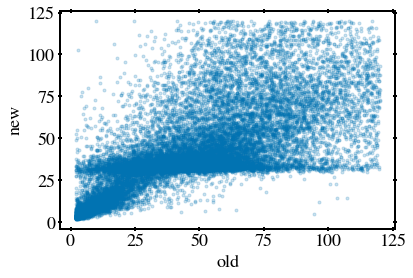

In [165]:
plt.figure()
plt.scatter(numaxtable['numax_1'],
            numaxtable['numax_2'], marker='.', alpha=0.2)
plt.xlabel('old')
plt.ylabel('new')

In [167]:
numaxtable

corot_id,numax_1,origin_estimatenumax_1,flag_estimatenumax_1,numax_2,origin_estimatenumax_2,flag_estimatenumax_2
int64,float64,int64,str4,float64,int64,str4
100401721,83.92779567521774,1,True,53.283071158213964,0,True
100402467,47.62961135377252,1,True,41.55547098719493,0,True
100405256,37.758235691178626,1,True,36.132448513674795,0,True
100407529,24.71611178612763,1,True,38.260250580889775,0,True
100408489,117.11078892432492,1,True,106.7773775666729,0,True
100411312,10.287044784575738,1,True,32.82977029432324,0,True
...,...,...,...,...,...,...
738644774,37.8775852999666,0,True,62.953142084587746,0,True
738645059,110.31967374428173,1,True,48.878826941944155,0,True


In [175]:
print(numaxtable['numax_1'] - numaxtable['numax_2'])

      numax_1      
-------------------
 30.644724517003773
  6.074140366577588
  1.625787177503831
-13.544138794762144
 10.333411357652025
-22.542725509747502
                ...
-13.903215863005752
 -25.07555678462115
 61.440846802337575
 -7.555477283398169
  5.367422149367002
-2.8356525790731695
-16.004385498424767
Length = 22920 rows


In [173]:
numaxtable[numaxtable['corot_id'] == 100461740]

corot_id,numax_1,origin_estimatenumax_1,flag_estimatenumax_1,numax_2,origin_estimatenumax_2,flag_estimatenumax_2
int64,float64,int64,str4,float64,int64,str4
100461740,97.9156679707928,1,True,50.0841013684876,0,True


# Stats

In [23]:
for specific_runid in runs:
    print('')
    print(f'For {specific_runid}')
    runmask = [specific_runid in run_ids for run_ids in spectrotable_new['run_ids']]
    print('Number of stars in new table', np.sum(runmask))
    print('Number of unique stars based on corot_id', len(np.unique(spectrotable_new['corot_id'][runmask])))
    print('Number of unique source_id', len(np.unique(spectrotable_new['source_id'][runmask])))


For IRa01
Number of stars in new table 2018
Number of unique stars based on corot_id 2018
Number of unique source_id 2018

For LRa01
Number of stars in new table 2414
Number of unique stars based on corot_id 2414
Number of unique source_id 2414

For LRa02
Number of stars in new table 1896
Number of unique stars based on corot_id 1896
Number of unique source_id 1896

For LRa03
Number of stars in new table 1248
Number of unique stars based on corot_id 1248
Number of unique source_id 1248

For LRa04
Number of stars in new table 1077
Number of unique stars based on corot_id 1077
Number of unique source_id 1077

For LRa05
Number of stars in new table 1057
Number of unique stars based on corot_id 1057
Number of unique source_id 1057

For LRa06
Number of stars in new table 1445
Number of unique stars based on corot_id 1445
Number of unique source_id 1445

For LRa07
Number of stars in new table 1221
Number of unique stars based on corot_id 1221
Number of unique source_id 1221

For LRc01
Numbe

In [24]:
print(np.sum(spectrotable_new['run_ids'].mask))

16239


In [21]:
len(set(spectrotable_new['corot_id']) - set(starruns.keys()))

16239

In [22]:
len(set(starruns.keys()) - set(spectrotable_new['corot_id']) )

317

# Was the selection based on corot run ids?

In [34]:
notruns = []
notlcruns = []
lcruns = []
for star in spectrotable:
    if star['run_id'] not in runs:
        notruns.append(star['corot_id'])
        notlcruns.append(star['run_id'])
    else:
        lcruns.append(star['corot_id'])

In [35]:
np.unique(notlcruns)

array(['SRa01', 'SRa02', 'SRa03', 'SRa04', 'SRa05', 'SRc01', 'SRc02'],
      dtype='<U5')

In [53]:
notruns

[205846322,
 205847884,
 205848144,
 205849550,
 205850161,
 205851789,
 205851917,
 205852402,
 205854009,
 205854191,
 205854745,
 205855078,
 205855414,
 205855431,
 205855475,
 205856048,
 205857053,
 205857787,
 205858104,
 205858261,
 205858309,
 205858848,
 205859034,
 205859071,
 205859944,
 205860165,
 205861134,
 205861778,
 205862255,
 205862520,
 205862545,
 205862788,
 205863521,
 205863732,
 205864056,
 205864057,
 205864125,
 205864199,
 205864599,
 205864991,
 205866114,
 205866127,
 205866133,
 205866506,
 205866587,
 205866986,
 205867205,
 205867521,
 205867701,
 205867973,
 205868702,
 205868875,
 205869245,
 205869280,
 205869287,
 205869366,
 205869615,
 205869708,
 205870318,
 205870449,
 205870454,
 205870600,
 205870910,
 205870940,
 205871189,
 205871292,
 205871731,
 205871767,
 205871768,
 205871856,
 205872557,
 205872574,
 205872731,
 205872832,
 205873000,
 205873094,
 205873105,
 205873195,
 205873386,
 205873444,
 205873450,
 205873648,
 205873700,
 205

In [54]:
# Some stars have been observed in both short and long cadence
print(np.unique(writetable[np.isin(writetable['corot_id'], list(notruns))]['run_ids']))

 run_ids 
---------
       --
['LRa07']
